In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Load the A/B Testing Dataset**

We loaded our dataset from a CSV file. This dataset contains user behavior data from an online experiment — perfect for comparing the performance of two versions of a web page.



In [3]:
df = pd.read_csv("ab_data.csv")

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Checking Group Mismatches (Treatment, Control)**

We filtered for rows where users are in the treatment group but did not see the new_page.
This helps identify inconsistencies in the experiment design — critical for data quality

In [13]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


In [15]:
df = df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) | 
        ((df['group'] == 'control') & (df['landing_page'] != 'old_page'))]


In [17]:
df.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


**Group Summary** 

We counted how many users are in each group. This helps us check if the experiment was fairly split.(a key concern for stakeholders)

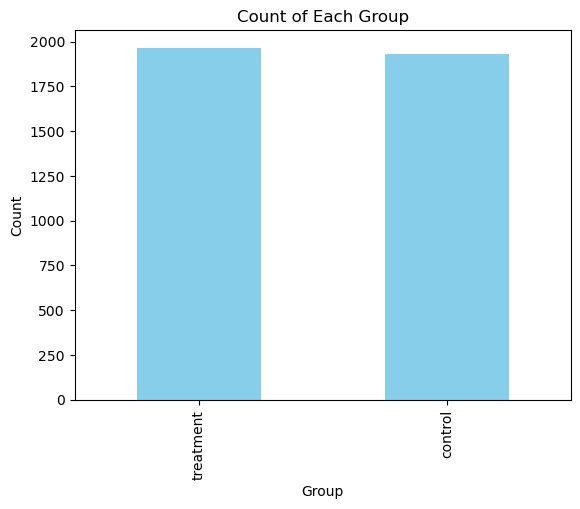

In [26]:
df['group'].value_counts().plot(kind='bar', color='skyblue')

plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Count of Each Group')

plt.show()

In [28]:
df['group'].value_counts()

group
treatment    1965
control      1928
Name: count, dtype: int64

In [30]:
len(df) == 1965 + 1928

True

**Conversion Rates by Group**

We calculated how many users converted in each group. This gives us the performance of each version from a business value angle.

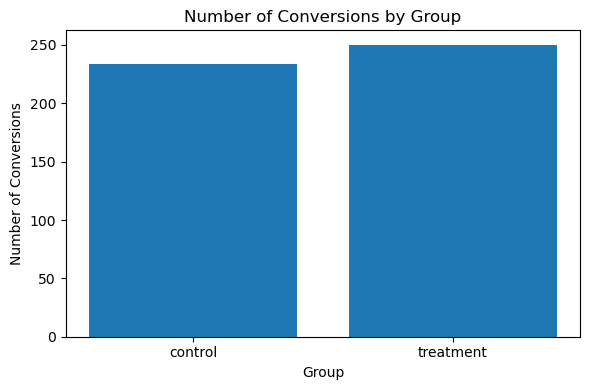

In [37]:
# Group and count converted users by group
conversion_counts = df[df['converted'] == 1].groupby('group').size().reset_index(name='count')

# Plot
plt.figure(figsize=(6, 4))
plt.bar(conversion_counts['group'], conversion_counts['count'])
plt.title('Number of Conversions by Group')
plt.xlabel('Group')
plt.ylabel('Number of Conversions')
plt.tight_layout()
plt.show()


In [41]:
conversion_counts
conversion_counts.value_counts()

group      count
control    234      1
treatment  250      1
Name: count, dtype: int64

In [35]:
control_group_converted = df[(df['group'] == 'control') & (df['converted'] == 1)]

conversion_rate_a = len(control_group_converted) / len(df[df['group'] == 'control'])
print(conversion_rate_a)


0.12136929460580913


In [43]:
treatment_group_converted = df[(df['group'] == 'treatment') & (df['converted'] == 1)]

conversion_rate_b = len(treatment_group_converted) / len(df[df['group'] == 'treatment'])
print(conversion_rate_b)

0.1272264631043257


**Proportion Z-Test**

We applied a traditional statistical method to check if the conversion difference is significant — asking “is this result likely just due to random chance?”

In [48]:
from statsmodels.stats.proportion import proportions_ztest

convert_control = df[df['group'] == 'control']['converted'].sum()
convert_treatment = df[df['group'] == 'treatment']['converted'].sum()

n_control = df[df['group'] == 'control'].shape[0]
n_treatment = df[df['group'] == 'treatment'].shape[0]

counts = [convert_control, convert_treatment]
nobs = [n_control, n_treatment]

z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='two-sided')

print(f"Z-statistic: {z_stat:.5}")
print(f"P-value: {p_value:.5f}")

Z-statistic: -0.55377
P-value: 0.57974


**Z-Test Results**

We reviewed the p-value and z-statistic. A low p-value would suggest the change has measurable impact. in this case we accept the H0 (null hyphothesis) since it's not less than 0.05.

**Bayesian Setup**

We prepared the counts for Bayesian analysis. This allows us to estimate probability distributions for conversion rates.

Probability that treatment is better: 0.707


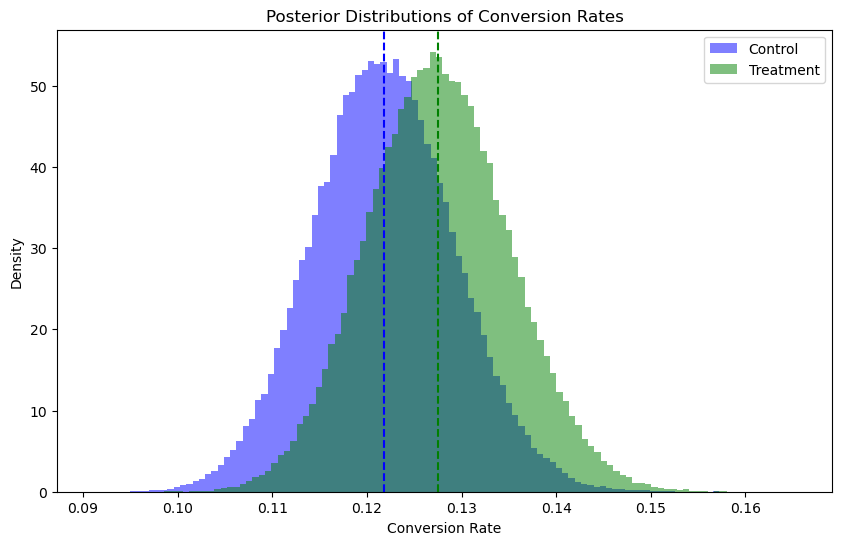

In [54]:
from scipy.stats import beta

control_data = df[df['group'] == 'control']['converted']
control_success = control_data.sum()
control_total = control_data.count()

treatment_data = df[df['group'] == 'treatment']['converted']
treatment_success = treatment_data.sum()
treatment_total = treatment_data.count()

alpha_c, beta_c = control_success + 1, control_total - control_success + 1
alpha_t, beta_t = treatment_success + 1, treatment_total - treatment_success + 1

samples = 100_000
control_posterior = beta.rvs(alpha_c, beta_c, size=samples)
treatment_posterior = beta.rvs(alpha_t, beta_t, size=samples)

prob_treatment_better = (treatment_posterior > control_posterior).mean()
print(f"Probability that treatment is better: {prob_treatment_better:.3f}")

# Plot posterior distributions
plt.figure(figsize=(10,6))
plt.hist(control_posterior, bins=100, alpha=0.5, label='Control', color='blue', density=True)
plt.hist(treatment_posterior, bins=100, alpha=0.5, label='Treatment', color='green', density=True)
plt.axvline(control_posterior.mean(), color='blue', linestyle='--')
plt.axvline(treatment_posterior.mean(), color='green', linestyle='--')
plt.title("Posterior Distributions of Conversion Rates")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.show()

**Beta Distribution Sampling**

We simulated conversion rate probabilities using Bayesian inference — this shows not just the average, but the full uncertainty.



**Probability that Treatment is Better**

Instead of “significant or not,” we asked: what’s the chance that treatment performs better? This provides clearer insight for decision-makers

In [60]:
np.percentile(treatment_posterior, [2.5, 97.5])

array([0.11314167, 0.14260046])

**Is the Treatment Better?**

While traditional hypothesis testing (i.e., p-values) did not show a statistically significant difference, our Bayesian analysis estimates a 70% probability that the treatment outperforms the control.

From a business standpoint, this is promising but not conclusive. A 70% probability indicates moderate evidence that the new page could lead to improved conversions — not yet strong enough to justify a full-scale rollout.

**Recommended Next Steps:**

- Increase sample size with a new A/B test to boost confidence.

- Explore segment-level analysis to identify groups where the treatment may have stronger impact.

- Bayesian analysis enables decision-making under uncertainty by providing probabilistic insights rather than binary outcomes. In this case, the treatment variant shows potential, but further validation is recommended before committing to implementation.

